# Practice Numba cuda 2<br>

1) Explore numba's capabilities as described in the documentation section "Device detection and enquiry". 

    a) Write and execute code to get numba to print information about your GPU including the model number, compute capability, and amount of available memory. (Include your code in the template and copy/paste the info  you obtain about your device as comments.)

    b) Estimate (by hand calculation) the number of 64-bit floats you can store on your GPU based on your result from p1.

2)  Modify the parallel version of the _map_ app to use arrays of 64-bit floats, and experiment with running the modified code for different array sizes.

    a) How many 64-bit floats were in the largest array you could run successfully?

    b) What error message was generated if you requested a larger array?

3) Consider the code included in the python_logistic_map notebook that computes the bifurcation diagram of the logistic map.

    a) Locate the `for` loops in the logistic map code. What quantity is iterated over in each loop?

    b) For which loop are the computations in each iteration independent of one another? Briefly explain the reasoning behind your response.

    c) Implement a parallel version of the code to compute the bifurcation diagram of the logistic map.

    d) Modify both the serial and parallel codes to print the time required to perform the computation. Determine the time requried to compute 1000 iterations for 1000 parameter values, and report the "acceleration" factor; i.e. the ratio of serial run time over parallel run time.

4) In practic file p1_parallel you created serial code to compute the Mandelbrot set. Now consider creating a parallel  version. 

    a) What do the `for` loops in the serial code iterate over? For which loops are the computations for each iteration independent of one another? Briefly explain the reasoning behind your reply.

    b) Write a numba implementation that a lunches a 2D computational grid to parallelize the appropriate loops. Run your parallel code and verify that it reproduces the results of the serial version. 
    
    Also run your code to answer the questions below:
    
    c) What is the finest resolution 2D grid can you run on your GPU? What error message is generated by attempting finer grid resolution?

    d) What is the largest square block that you can run on your GPU? What error message is generated if you request more threads in each block?




problem1:
GPU memory in GB:  3.8201904296875
Compute capability (Major, Minor):  (7, 5)
GPU Model Name:  b'GeForce GTX 1650 with Max-Q Design'
Max float64 count:  512737280
GPU memory in GB:  3.8201904296875'
Compute capability (Major, Minor):  (7, 5)
GPU Model Name:  b'GeForce GTX 1650 with Max-Q Design
Max float64 count:  512737280

problem2:
largest array run succssfully at (float64) 2


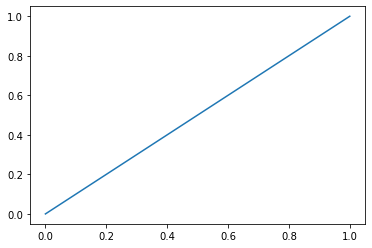

largest array run succssfully at (float64): 2

problem3:
In the fucntion, first for loop iterate before sotring results and seonc for loop interate to store
The loop in eath iteration at logsit_map_kernel function are the computations that independent of one another.
Parallel run time(second) =  0.2012310028076172


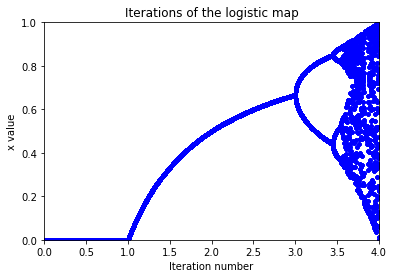

Serial run time(second) =  0.4665205478668213


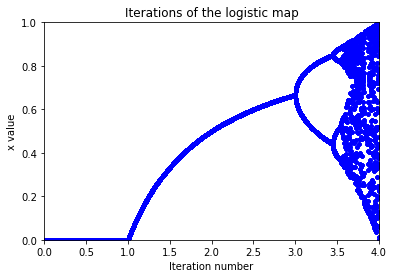

Acceleration factor (serial run time over parallel run time) =  2.3183333649280113
Problem 4


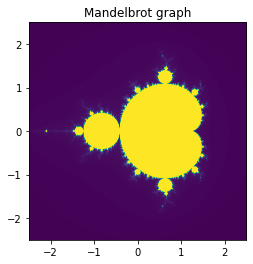

In [1]:
import numpy as np
from numba import cuda
import math
import matplotlib.pyplot as plt
import time
# import map_parallel

def gpu_total_memory():
	'''
	Query the GPU's properties via Numba to obtain the total memory of the device.
	'''
#  resources[in course reference]::   https://numba.pydata.org/numba-doc/dev/cuda-reference/host.html
	## numba.cuda.current_context(devnum=None) # Get the current device or use a device by device number, and return the CUDA context
	## cuda.current_context() # force cuda initialize
	## get_memory_info(self) # return(free, total) memory in bytes in the context
	return cuda.current_context().get_memory_info()[1]
# 	pass

def gpu_compute_capability():
	'''
	Query the GPU's properties via Numba to obtain the compute capability of the device.
	'''
    ## numba.cuda.get_current_device() # Get current device associated with the current thread
	## compute_capability # A tuple, (major, minor) indicating the supported compute capability
	return cuda.get_current_device().compute_capability
# 	pass

def gpu_name():
	'''
	Query the GPU's properties via Numba to obtain the name of the device.
	'''
    ## name # The name of the device (e.g. “GeForce GTX 970”)
	return cuda.get_current_device().name
# 	pass

def max_float64s():
	'''
	Compute the maximum number of 64-bit floats that can be stored on the GPU
	'''
    ## 1 B = 8 bits(1Byte)
    ## maxnum = gpumemory(GB) x (8 bits/1B ) /64 bit
	return int(gpu_total_memory()/8)
# 	pass
# -----------------------------------------  #


def map_64():
	'''
	Execute the map app modified to use 64-bit floats
	'''
# 	from map_parallel import sArray
#     import map_parallel
	M=512737280/2  #277 # it matter for length of code
	nn = max_float64s()/M # maximum
	print('largest array run succssfully at (float64)',int(nn))
	nx = np.linspace(0, 1, int(nn), dtype = np.float64)
	ny = np.array(nx)
	plt.plot(nx,ny)
	plt.show()

@cuda.jit(device = True) #gpu
def f(x, r):
	'''
	Execute 1 iteration of the logistic map
	'''
	return r*x*(1 - x)





@cuda.jit
def logistic_map_kernel(ss, r, x, transient, steady):
	'''
	Kernel for parallel iteration of logistic map

	Arguments:
		ss: 2D numpy device array to store steady state iterates for each value of r
		r: 1D  numpy device array of parameter values
		x: float initial value
		transient: int number of iterations before storing results
		steady: int number of iterations to store
	'''
    # reference python_logistic_map.ipynb [66] bifurcation    
    # reference ch2_map_nb.ipynb # compare parallel and serial section
	n = r.shape[0]
	# The argument of 'grid()' inidicates the dimenstion of the computational grid.
	i = cuda.grid(1) # w have a one-dimensiional grid
	if i < n:
#       python_logistic_map.ipynb [66] bifurcation 
		x_old = x0 #assign the initial value
		for k in range(transient):
			x_new = f(x_old, r[i])
			x_old = x_new
		for k in range(steady): #iterate over the desired sequence
			ss[k][i] = x_old
			x_new = f(x_old, r[i]) #compute the output value and assign to variable x_new
			x_old = x_new #assign the new (output) value top be the old (input) value for the next
# 	return ss
	    
	
	
	
	        
    
    
# -----------------------------------------from: python_logistic_map.ipynb
# def logisticSteadyArray(x0,r,n_transient, n_ss):
#     '''
#     Conpute an array of iterates of the logistic map f(x)=r*x*(1-x)
    
#     Inputs:
#         x0: float initial value
#         r: float parameter value
#         n_transient: int number of initial iterates to NOT store
#         n_ss: int number of iterates to store
        
#     Returns:
#         x: numpy array of n float64 values
#     '''
#     #create an array to hold n elements (each a 64 bit float)
#     x = np.zeros(n_ss, dtype=np.float64) 
#     x_old = x0 #assign the initial value
#     for i in range(n_transient):
#         x_new = f(x_old, r)
#         x_old = x_new
#     for i in range(n_ss): #iterate over the desired sequence
#         x[i] = x_old
#         x_new = f(x_old, r) #compute the output value and assign to variable x_new
#         x_old = x_new #assign the new (output) value top be the old (input) value for the next iterate
#     return x

# # -----------------------------------------
    
    
# 	pass



def parallel_logistic_map(r, x, transient, steady):
	'''
	Parallel iteration of the logistic map

	Arguments:
		r: 1D numpy array of float64 parameter values
		x: float initial value
		transient: int number of iterations before storing results
		steady: int number of iterations to store
	Return:
		2D numpy array of steady iterates for each entry in r
	'''
    # reference ch2_map_nb.ipynb # compare parallel and serial section
	TPB = 32
	n = r.shape[0]
	d_r = cuda.to_device(r)
	d_ss = cuda.device_array([steady,n], dtype = np.float64)
	blockdims = TPB
	gridDims = (n+TPB-1)//TPB
	logistic_map_kernel[gridDims, blockdims](d_ss, d_r, x, transient, steady)
	return d_ss.copy_to_host()



def serial_logistic_map(r, x, transient, steady):
	'''
	Kernel for parallel iteration of logistic map

	Arguments:
		ss: 2D numpy device array to store steady state iterates for each value of r
		r: 1D  numpy device array of parameter values
		x: float initial value
		transient: int number of iterations before storing results
		steady: int number of iterations to store
	'''
    # reference python_logistic_map.ipynb [66] bifurcation    
    # reference ch2_map_nb.ipynb # compare parallel and serial section
	n = r.shape[0]
	# The argument of 'grid()' inidicates the dimenstion of the computational grid.
# 	i = cuda.grid(1) # w have a one-dimensiional grid
	#create an array to hold n elements (each a 64 bit float)
# 	x = np.zeros(n_ss, dtype=np.float64) 
	ss = np.zeros([steady, n], dtype=np.float64)
# 	x_old = x0 #assign the initial value
	for i in range(n):
# 	if i < n:
#       python_logistic_map.ipynb [66] bifurcation 
		x_old = x #assign the initial value
		for k in range(transient):
			x_new = r[i]*x_old*(1 - x_old)
			x_old = x_new
		for k in range(steady): #iterate over the desired sequence
			ss[k][i] = x_old
			x_new = r[i]*x_old*(1 - x_old) #compute the output value and assign to variable x_new
			x_old = x_new #assign the new (output) value top be the old (input) value for the next
	return ss




# -----------------------------------------  ## -----------------------------------------  ## -----------------------------------------  #




@cuda.jit(device = True)
def iteration_count(cx, cy, dist, itrs):
	'''
	Computed number of Mandelbrot iterations

	Arguments:
		cx, cy: float64 parameter values
		dist: float64 escape threshold
		itrs: int iteration count limit
	'''
	#from previous HW1 p5escape   
	x = 0
	y = 0
	for i in range(itrs):
		r = math.sqrt(x**2 + y**2)
		if dist > r:
			x_n = x**2 - y**2 + cx 
			y_n = 2*x*y + cy
			x = x_n
			y = y_n
		else: break
	return i
	# pass
	# 
    # xtemp := x×x - y×y + x0
    # y := 2×x×y + y0
    # x := xtemp
    # iteration := iteration + 1
# 	pass

@cuda.jit
def mandelbrot_kernel(out, cx, cy, dist, itrs):
	'''
	Kernel for parallel computation of Mandelbrot iteration counts

	Arguments:
		out: 2D numpy device array for storing computed iteration counts
		cx, cy: 1D numpy device arrays of parameter values
		dist: float64 escape threshold
		itrs: int iteration count limit
	'''
	i,j = cuda.grid(2)
	nx,ny = out.shape
	if i < nx and j < ny:
		out[i,j] = iteration_count(cx[j],cy[i],dist,itrs)


def parallel_mandelbrot(cx, cy, dist, itrs):
	'''
	Parallel computation of Mandelbrot iteration counts

	Arguments:
		cx, cy: 1D numpy arrays of parameter values
		dist: float64 escape threshold
		itrs: int iteration count limit
	Return:
		2D numpy array of iteration counts
	'''
	TPBx = 32
	TPBy = 32
	nx = cx.shape[0]
	ny = cy.shape[0]
	d_cx = cuda.to_device(cx)
	d_cy = cuda.to_device(cy)
	out = cuda.device_array((nx, ny), dtype = np.float64)
	gridDims = ((nx + TPBx - 1) // TPBx , (ny + TPBy - 1) // TPBy)
	blockDims = (TPBx,TPBy)
	mandelbrot_kernel[gridDims, blockDims](out, d_cx, d_cy, dist, itrs)
	return out.copy_to_host()





if __name__ == "__main__":
	print('problem1:')
	#Problem 1
	print("GPU memory in GB: ", gpu_total_memory()/1024**3)
	print("Compute capability (Major, Minor): ", gpu_compute_capability())
	print("GPU Model Name: ", gpu_name())
	print("Max float64 count: ", max_float64s())

	#PASTE YOUR OUTPUT HERE#
	print('GPU memory in GB:  3.8201904296875\'')
	print('Compute capability (Major, Minor):  (7, 5)')
	print('GPU Model Name:  b\'GeForce GTX 1650 with Max-Q Design')
	print('Max float64 count:  512737280')

	#Problem 2
	print('\nproblem2:')    
	map_64()
	print('largest array run succssfully at (float64): 2')
	#PASTE YOUR ERROR MESSAGES HERE#
# 	print('ERROR MESSAGES in problem2:')
# 	print('Kernel Restarting')
# 	print('#numba.cuda.cudadrv.driver.CudaAPIError: [2] Call to cuMemAlloc results in CUDA_ERROR_OUT_OF_MEMORY')



	#Problem 3
	print('\nproblem3:')
    #3a)
	print('In the fucntion, first for loop iterate before sotring results and seonc for loop interate to store')    
    #3b)
	print('The loop in eath iteration at logsit_map_kernel function are the computations that independent of one another.')
    
# 	compute 1000 iterations for 1000 parameter values
	#define sequence of r values
    #initialize parameters for iteration sequences
	n_ss = 8 #number of "steady-state" iterates to store
	n_transient = 992 #number of transient iterates that are not store
	x0 = 0.5 #initial value of x
	rmin = 0
	rmax = 4
	m = 1000 #number of r values
	# Create the m equally spaced values of r using linspace
	r = np.linspace(rmin,rmax,m)

	t0 = time.time()
	tmp = parallel_logistic_map(r, x0, n_transient, n_ss) #compute the steady-state array
	t1 = time.time()
	tp = t1-t0   
	print('Parallel run time(second) = ', tp)

	plt.figure()
	for i in range(n_ss):
		plt.plot(r,tmp.transpose(), 'b.')
	plt.axis([rmin,rmax, 0, 1])
	plt.xlabel('Iteration number')
	plt.ylabel('x value')
	plt.title('Iterations of the logistic map')    
	plt.show()

    #serial part
	t0 = time.time()
	tmp_s = serial_logistic_map(r, x0, n_transient, n_ss) #compute the steady-state array
	t1 = time.time()
	ts = t1-t0    
	print('Serial run time(second) = ', ts)
# 	print(tmp_s)   

	plt.figure()
	for i in range(n_ss):
		plt.plot(r,tmp_s.transpose(), 'b.')
	plt.axis([rmin,rmax, 0, 1])
	plt.xlabel('Iteration number')
	plt.ylabel('x value')
	plt.title('Iterations of the logistic map')    
	plt.show()


	print('Acceleration factor (serial run time over parallel run time) = ', ts/tp)
    

    
    
	#Problem 4
	print('Problem 4')	
	#4a)
    # In ther for loop in itration_count function, the x and y value is updated each iteration which it independet of one another
    #4b)
	nx = 5523
	ny = 5523
	dist = 2.5
	itrs = 256
	cx = np.linspace(-2, 1, nx)
	cy = np.linspace(-1.5, 1.5, ny)
	f = parallel_mandelbrot(cx, cy, dist, itrs)
	plt.figure()
	plt.imshow(f, extent = (-2.5, 2.5, -2.5, 2.5))
	plt.title('Mandelbrot graph')
	plt.show()
	